# Importing Libraries

In [1]:
import csv
import json
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

# Importing Tables

In [2]:
rt_reviews_df = pd.read_csv('../Data/rt.reviews.tsv',
                           delimiter='\t',
                           encoding=('unicode_escape'))

In [3]:
tnmovie = pd.read_csv('../Data/tn.movie_budgets.csv', parse_dates = ['release_date'])

In [4]:
bom = pd.read_csv('../Data/bom.movie_gross.csv')

In [5]:
rt_movie_info = pd.read_csv('../Data/rt.movie_info.tsv',
                           delimiter = '\t')

# Importing SQL Database

In [6]:
conn = sqlite3.connect('../Data/im.db')

# List of SQL Tables

In [7]:
pd.read_sql('''
SELECT
    *
FROM
    sqlite_master

''',conn)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


# Viewing Table Heads to Locate Relevant Columns

### Rotten Tomatoes Reviews

In [8]:
rt_reviews_df.head(2)

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"


In [9]:
rt_reviews_df.shape

(54432, 8)

Things to notice here are that the id is obviously an ID they use for the movie title. Date is not the release date of the movie rather the date of the review.

### Rotten Tomatoes Movie Info

In [10]:
rt_movie_info.head(2)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One


In [11]:
rt_movie_info.shape

(1560, 12)

It seems that because this database does not include the title of the films that, even though it has a lot of review data, it is unusable for our purposes.

### Box Office Mojo

In [12]:
bom.head(2)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010


Does not contain any review data.

### The Numbers

In [13]:
tnmovie.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


Does not contain any review data.

### IMDB

#### Movie Ratings

In [14]:
pd.read_sql('''
SELECT
    *
FROM
    movie_ratings

''',conn)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


This looks promising, will have to join on movie ID to make useable DF.

#### Movie Basics

In [15]:
cleaned_movie_basics = pd.read_sql('''
SELECT
    *
FROM
    movie_basics
WHERE
    movie_id IN (SELECT movie_id
                 FROM movie_ratings
                 WHERE numvotes > 700)

''',conn)

# Joining Movie Basics and Movie Ratings

In [16]:
pd.read_sql('''
SELECT
    *
FROM
    movie_basics
JOIN movie_ratings
USING (movie_id)
WHERE
    movie_id IN (SELECT movie_id
                 FROM movie_ratings
                 WHERE numvotes > 700)
''',conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
1,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248
2,tt0293069,Dark Blood,Dark Blood,2012,86.0,Thriller,6.6,1053
3,tt0315642,Wazir,Wazir,2016,103.0,"Action,Crime,Drama",7.1,15378
4,tt0323808,The Wicker Tree,The Wicker Tree,2011,96.0,"Drama,Horror",3.9,2328
...,...,...,...,...,...,...,...,...
11625,tt9573980,Leaving Neverland,Leaving Neverland,2019,240.0,Documentary,7.1,19632
11626,tt9597190,Pegasus,Fei chi ren sheng,2019,98.0,"Comedy,Sport",6.4,817
11627,tt9778170,Panodrama,Panodrama,2019,64.0,Documentary,3.1,2220
11628,tt9815714,The Hard Way,The Hard Way,2019,92.0,Action,4.7,1214


In [17]:
review_id_df = pd.read_sql('''
SELECT
    *
FROM
    movie_basics
JOIN movie_ratings
USING (movie_id)
WHERE
    movie_id IN (SELECT movie_id
                 FROM movie_ratings
                 WHERE numvotes > 700)
''',conn)

# Creating Scatter Plot for Numvotes vs AverageRating

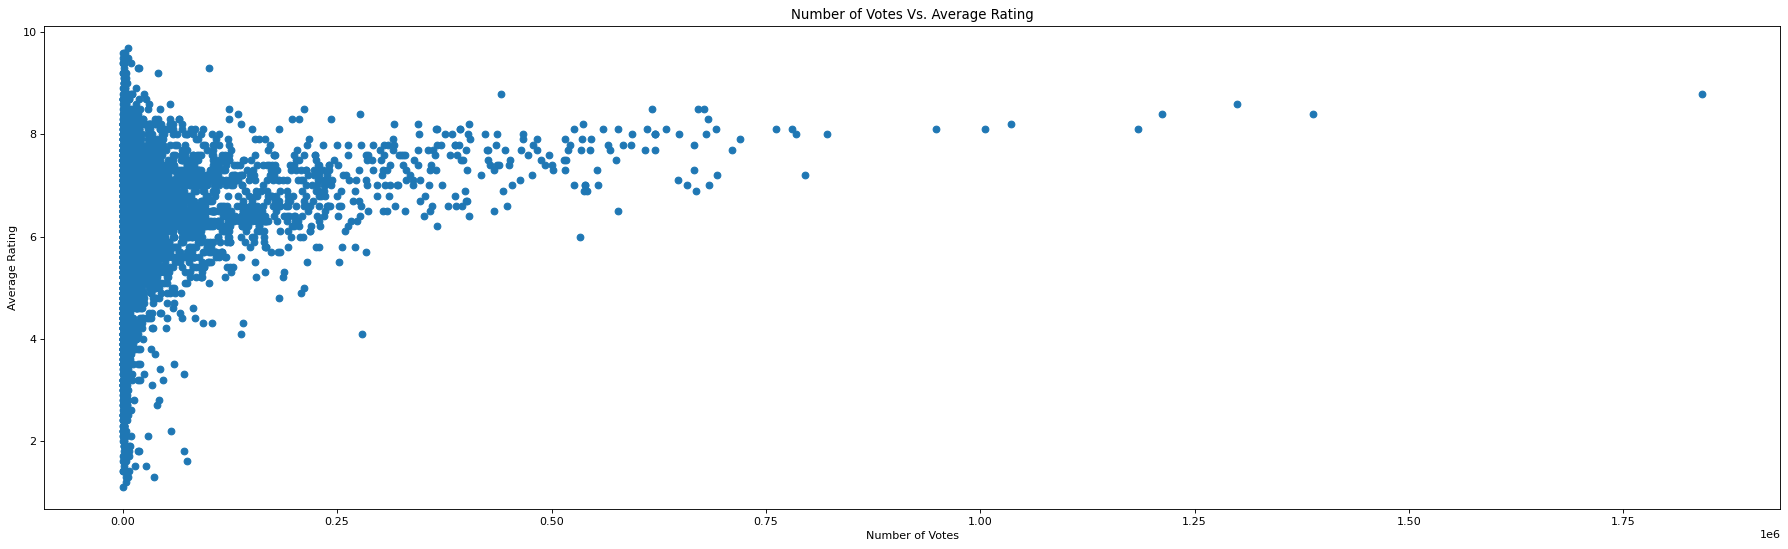

In [18]:
plt.figure(figsize=(28, 8), dpi=80)
rating_vs_num_reviews = plt.scatter(x = review_id_df['numvotes'], y = review_id_df['averagerating'])
plt.title('Number of Votes Vs. Average Rating')
plt.xlabel('Number of Votes')
plt.ylabel('Average Rating')
plt.show();

It seems like the metrics of number of reviews vs average rating isnt going to be all that important to the big wigs. I should probably add profit to this!

# Formatting 'The Numbers' DF

In [19]:
tnmovie['worldwide_gross'] = tnmovie['worldwide_gross'].str.replace("\$|,|\.", '', regex = True).astype(int)
tnmovie['production_budget'] = tnmovie['production_budget'].str.replace("\$|,|\.", '', regex = True).astype(int)

# Creating 'Profit Column' from WWGross and Production Budget

In [20]:
tnmovie['profit'] = tnmovie['worldwide_gross'] - tnmovie['production_budget']

In [21]:
tnmovie['ROI'] = (tnmovie['profit'] / tnmovie['production_budget']) *100

In [22]:
tnmovie.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,ROI
0,1,2009-12-18,Avatar,425000000,"$760,507,625",2776345279,2351345279,553.257713
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,"$241,063,875",1045663875,635063875,154.667286
2,3,2019-06-07,Dark Phoenix,350000000,"$42,762,350",149762350,-200237650,-57.210757
3,4,2015-05-01,Avengers: Age of Ultron,330600000,"$459,005,868",1403013963,1072413963,324.384139
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,"$620,181,382",1316721747,999721747,315.369636


In [23]:
tnmovie.shape

(5782, 8)

It will be important to when combining DF's that we try and preserve as many of these rows as possible.

# Create Simple The Numbers DF

In [24]:
q = '''SELECT 
            movie,
            profit,
            ROI
       FROM tnmovie
       ORDER BY
           profit DESC;'''
tnmovies_title_profit = pysqldf(q)
tnmovies_title_profit

,movie,profit,ROI
0,Avatar,2351345279,553.257713
1,Titanic,2008208395,1004.104198
2,Avengers: Infinity War,1748134200,582.711400
3,Star Wars Ep. VII: The Force Awakens,1747311220,571.016739
4,Jurassic World,1433854864,666.909239
...,...,...,...
5777,Town & Country,-94635231,-90.128791
5778,Men in Black: International,-106900000,-97.181818
5779,Mars Needs Moms,-110450242,-73.633495
5780,Moonfall,-150000000,-100.000000


In [161]:
review_id_df.head(2)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
1,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248


# Attempt One to Join The Numbers and IMDB

In [26]:
tn_imdb_profit = pd.merge(tnmovies_title_profit,
                  review_id_df,
                  left_on='movie',
                  right_on='primary_title',
                  )

In [27]:
tn_imdb_profit = tn_imdb_profit.drop_duplicates(subset = 'movie')

# Creation of NumReviews VS Profit Scatter

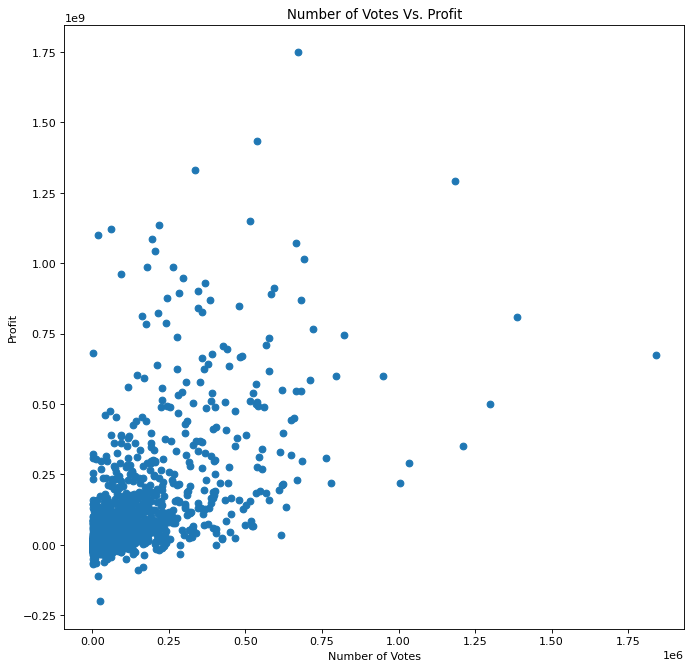

In [28]:
plt.figure(figsize=(10, 10), dpi=80)
numreviews_vs_profit = plt.scatter(x = tn_imdb_profit['numvotes'], y = tn_imdb_profit['profit'])
plt.title('Number of Votes Vs. Profit')
plt.xlabel('Number of Votes')
plt.ylabel('Profit')
plt.show();

In [160]:
tn_imdb_profit.head(2)

,movie,profit,ROI,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,averagerating_int
0,Avengers: Infinity War,1748134200,582.711400,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,670926,8.0
1,Jurassic World,1433854864,666.909239,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338,7.0


# Creation of Rating VS Profit

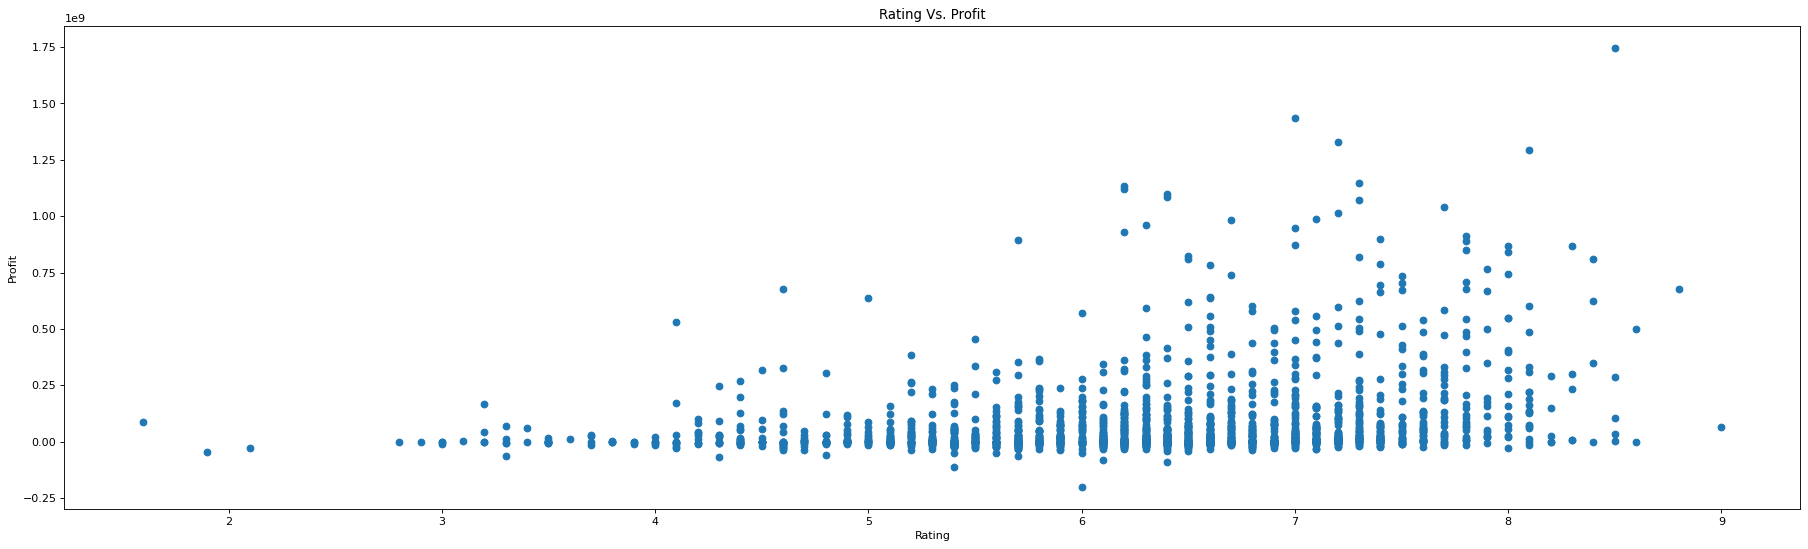

In [30]:
plt.figure(figsize=(28, 8), dpi=80)
numreviews_vs_profit = plt.scatter(x = tn_imdb_profit['averagerating'], y = tn_imdb_profit['profit'])
plt.title('Rating Vs. Profit')
plt.xlabel('Rating')
plt.ylabel('Profit')
plt.show();

# Creating Box and Whiskers for All Ratings Values

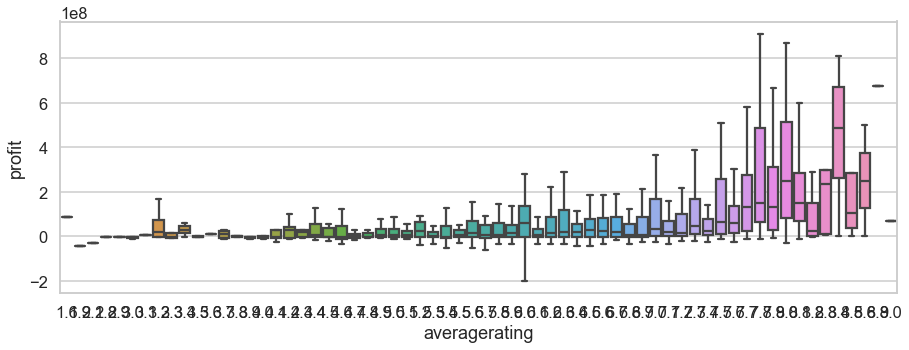

In [162]:
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(15,5))

# Plot distribution of column with highest correlation
sns.boxplot(
    x=tn_imdb_profit['averagerating'],
    y=tn_imdb_profit["profit"],
    showfliers = False,
    ax=ax1);

Well it's obvious I need to round these reviews out!

# Normalizing Reviews

In [32]:
tn_imdb_profit.head()

,movie,profit,ROI,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,Avengers: Infinity War,1748134200,582.711400,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,670926
1,Jurassic World,1433854864,666.909239,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338
2,Furious 7,1328722794,699.327786,tt2820852,Furious 7,Furious Seven,2015,137.0,"Action,Crime,Thriller",7.2,335074
3,The Avengers,1292935897,574.638176,tt0848228,The Avengers,The Avengers,2012,143.0,"Action,Adventure,Sci-Fi",8.1,1183655
5,Black Panther,1148258224,574.129112,tt1825683,Black Panther,Black Panther,2018,134.0,"Action,Adventure,Sci-Fi",7.3,516148


In [33]:
tn_imdb_profit['averagerating_int'] = tn_imdb_profit['averagerating'].round()

In [67]:
tn_imdb_profit.value_counts('averagerating_int')

averagerating_int
6.0    653
7.0    557
5.0    219
8.0    186
4.0     83
3.0     17
9.0      4
2.0      3
dtype: int64

# Removing Outliers ROI out of bounds

In [88]:
q3 = '''SELECT *
       FROM tn_imdb_profit
        ORDER BY
            ROI DESC; '''
mean_per_rating_todrop = pysqldf(q3)
mean_per_rating_todrop

,movie,profit,ROI,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,averagerating_int
0,The Gallows,41556474,41556.474000,tt2309260,The Gallows,The Gallows,2015,81.0,"Horror,Mystery,Thriller",4.2,17763,4.0
1,The Devil Inside,100759490,10075.949000,tt1560985,The Devil Inside,The Devil Inside,2012,83.0,Horror,4.2,33522,4.0
2,The Birth of a Nation,10890000,9900.000000,tt4196450,The Birth of a Nation,The Birth of a Nation,2016,120.0,"Biography,Drama,History",6.4,18442,6.0
3,Insidious,98370886,6558.059067,tt1591095,Insidious,Insidious,2010,103.0,"Horror,Mystery,Thriller",6.9,254197,7.0
4,Unfriended,63364198,6336.419800,tt3713166,Unfriended,Unfriended,2014,83.0,"Horror,Mystery,Thriller",5.6,62043,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1717,The Adventurer: The Curse of the Midas Box,-25000000,-100.000000,tt1376213,The Adventurer: The Curse of the Midas Box,The Adventurer: The Curse of the Midas Box,2013,100.0,"Adventure,Family,Fantasy",5.4,5257,5.0
1718,Reagan,-25000000,-100.000000,tt1822382,Reagan,Reagan,2011,105.0,"Biography,Documentary",7.4,732,7.0
1719,The Face of an Angel,-26000000,-100.000000,tt2967008,The Face of an Angel,The Face of an Angel,2014,101.0,"Crime,Drama",4.6,4211,5.0
1720,The Ridiculous 6,-60000000,-100.000000,tt2479478,The Ridiculous 6,The Ridiculous 6,2015,119.0,"Comedy,Western",4.8,38694,5.0


In [89]:
mean_clean = mean_per_rating_todrop.drop([0, 1])

In [138]:
mean_clean.shape

(1720, 12)

# Removing Justin Movie skewing Data

In [137]:
q4 = '''SELECT *
       FROM mean_clean
        ORDER BY 
        averagerating_int; '''
mean_clean_no_justin = pysqldf(q4)
mean_clean_no_justin

,movie,profit,ROI,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,averagerating_int
0,Justin Bieber: Never Say Never,86034125,661.800962,tt1702443,Justin Bieber: Never Say Never,Justin Bieber: Never Say Never,2011,105.0,"Documentary,Music",1.6,74978,2.0
1,United Passions,-29831168,-99.437227,tt2814362,United Passions,United Passions,2014,110.0,"Drama,History,Sport",2.1,3878,2.0
2,Foodfight!,-44926294,-99.836209,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,2.0
3,Slender Man,41723644,417.236440,tt5690360,Slender Man,Slender Man,2018,93.0,"Horror,Mystery,Thriller",3.2,19650,3.0
4,The Emoji Movie,166562312,333.124624,tt4877122,The Emoji Movie,The Emoji Movie,2017,86.0,"Adventure,Animation,Comedy",3.2,47294,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1715,Icarus,-6000000,-100.000000,tt6333060,Icarus,Icarus,2017,120.0,"Documentary,Sport,Thriller",7.9,28979,8.0
1716,Inception,675524642,422.202901,tt1375666,Inception,Inception,2010,148.0,"Action,Adventure,Sci-Fi",8.8,1841066,9.0
1717,Interstellar,501379375,303.866288,tt0816692,Interstellar,Interstellar,2014,169.0,"Adventure,Drama,Sci-Fi",8.6,1299334,9.0
1718,Frankenstein,67006296,148.902880,tt1795369,Frankenstein,National Theatre Live: Frankenstein,2011,130.0,Drama,9.0,1832,9.0


In [139]:
mean_clean_sans_justin = mean_clean_no_justin.drop([0])

In [140]:
mean_clean_sans_justin

,movie,profit,ROI,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,averagerating_int
1,United Passions,-29831168,-99.437227,tt2814362,United Passions,United Passions,2014,110.0,"Drama,History,Sport",2.1,3878,2.0
2,Foodfight!,-44926294,-99.836209,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,2.0
3,Slender Man,41723644,417.236440,tt5690360,Slender Man,Slender Man,2018,93.0,"Horror,Mystery,Thriller",3.2,19650,3.0
4,The Emoji Movie,166562312,333.124624,tt4877122,The Emoji Movie,The Emoji Movie,2017,86.0,"Adventure,Animation,Comedy",3.2,47294,3.0
5,Vampires Suck,61424988,307.124940,tt1666186,Vampires Suck,Vampires Suck,2010,82.0,Comedy,3.4,43984,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1715,Icarus,-6000000,-100.000000,tt6333060,Icarus,Icarus,2017,120.0,"Documentary,Sport,Thriller",7.9,28979,8.0
1716,Inception,675524642,422.202901,tt1375666,Inception,Inception,2010,148.0,"Action,Adventure,Sci-Fi",8.8,1841066,9.0
1717,Interstellar,501379375,303.866288,tt0816692,Interstellar,Interstellar,2014,169.0,"Adventure,Drama,Sci-Fi",8.6,1299334,9.0
1718,Frankenstein,67006296,148.902880,tt1795369,Frankenstein,National Theatre Live: Frankenstein,2011,130.0,Drama,9.0,1832,9.0


# Creating Box and Whiskers and Line Graph

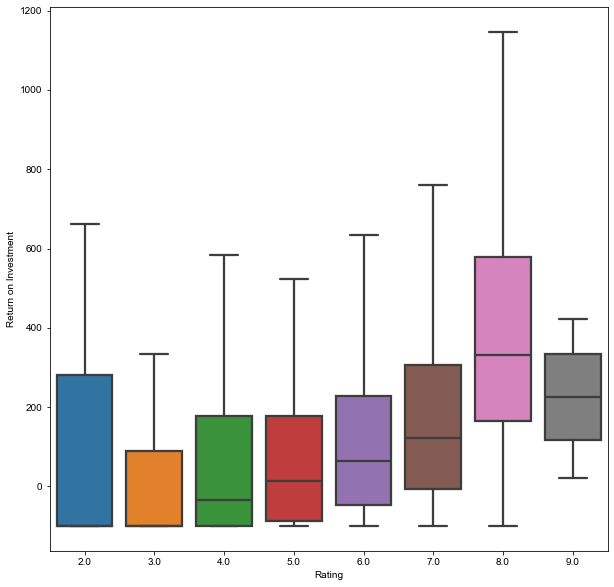

In [35]:
fig, ax1 = plt.subplots(figsize=(10,10))
sns.set_style("whitegrid")
sns.set_context("talk")

# Plot distribution of column with highest correlation
sns.boxplot(
    x=tn_imdb_profit['averagerating_int'],
    y=tn_imdb_profit["ROI"],
    showfliers = False,
    ax=ax1)
ax1.set(xlabel='Rating', ylabel='Return on Investment')
plt.show();

# Creation of ROI by Rating Line

In [182]:
import matplotlib.ticker as mtick

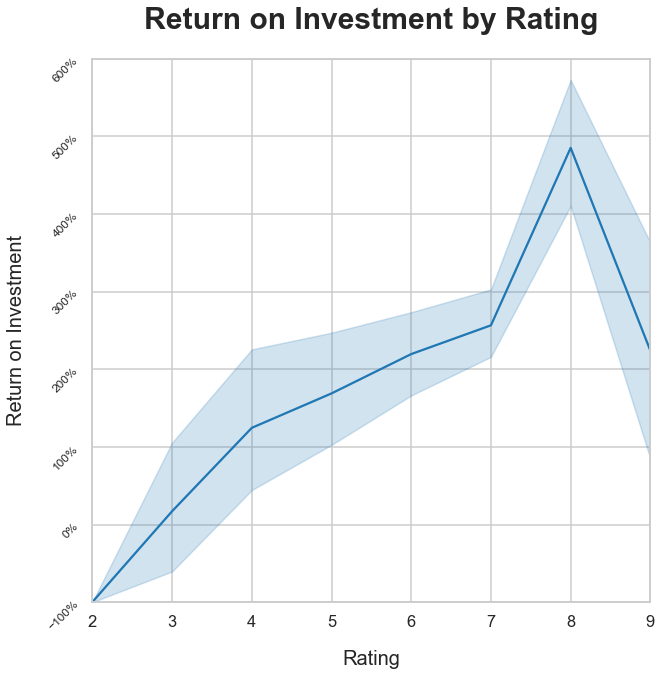

In [185]:
fig, ax2 = plt.subplots(figsize=(10,10))
sns.lineplot(data=mean_clean_sans_justin, x='averagerating_int', y="ROI", ax=ax2)

#Figure titles
plt.title('Return on Investment by Rating', fontsize = 30, fontweight='bold', pad = 30)
plt.xlabel('Rating', fontsize = 20, labelpad = 20)
plt.ylabel('Return on Investment', fontsize = 20, labelpad = 20)

#Setting the limits of the Graph
ax2.set_xlim(2, 9)
ax2.set_ylim(-100, 600)

#Messing with the ticks
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(symbol='%'))
plt.yticks(rotation = 45, fontsize = 12)

#plt.savefig('ROI.jpeg', dpi=120)
plt.show();

# Simple Df to create Simple Graph ROI vs. Rating

In [ ]:
mean_clean.value_counts('averagerating_int')

In [146]:
q2 = '''SELECT 
            AVG(ROI) AS avg_roi,
            averagerating_int AS Rating_Int
       FROM mean_clean_sans_justin
       GROUP BY
           averagerating_int
       ORDER BY
           averagerating_int; '''
mean_per_rating = pysqldf(q2)
mean_per_rating

,avg_roi,Rating_Int
0,-99.636718,2.0
1,17.252833,3.0
2,124.668370,4.0
3,168.981238,5.0
4,219.636980,6.0
5,256.678631,7.0
6,485.167271,8.0
7,223.988880,9.0


In [91]:
mean_per_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   avg_roi     8 non-null      float64
 1   Rating_Int  8 non-null      float64
dtypes: float64(2)
memory usage: 256.0 bytes


# Creation of Simple Graph

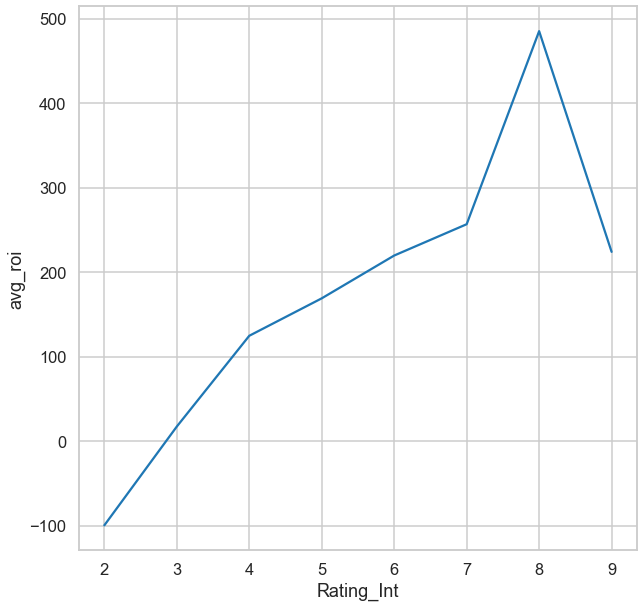

In [147]:
fig, ax1 = plt.subplots(figsize=(10,10))
sns.lineplot(data = mean_per_rating, x='Rating_Int', y='avg_roi');

Insights: It would appear from these graphs that movies that sit around an 8 on the ratings tend to be a good return on investment. You would assume that making the best rated movie would net you the most money but that does not appear to be the case. One thing that may explain this is that viewers would prefer to see a fun and exciting movie not a critically acclaimed one.